<a href="https://colab.research.google.com/github/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/blob/main/Taller%203/Laboratorio%203%20-%20Sesi%C3%B3n%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

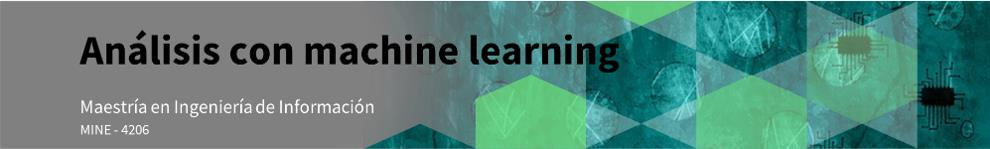

Uno de los campos más explorados en la Inteligencia Artificial es la Visión por Computador. Donde se intenta recrear la "identificación" de una imágen, combinando técnicas de recolección de imágenes, informática perimetral y modelos de aprendizaje automático. Sin embargo, las imágenes son Datos no Estructurados, donde solo se obtiene la información de los píxeles que guardan la información para que pueda ser visualizada en un computador.

Para ello, y ante la implementación de Redes Neuronales. Unos expertos han decidido utilizar estas técnicas para poder identificar tipos de flores dentro de un cultivo, esto con el fin de controlar las especies en ciertas zonas de interés, determinar cuales son las características de la flor y poder clasificarlas correctamente. 

## Objetivos

*   Aprender los conceptos básicos de una Red Neuronal.
*   Realizar la carga de imágenes para entrenar una Red Neuronal.
*   Entonar los hiperparámentros de una Red Neuronal.



## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 4.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


Este fragmento de código, nos permite evaluar si tenemos disponible una GPU dentro del ambiente de Google Colab.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1. Perfilamiento y entendimiento de los datos

Primero, descargamos los [datos](https://drive.google.com/file/d/1u_4g-yOgC4anxCM85COr_fqLCbgZJPf_/view?usp=sharing) y los extraemos dentro de la máquina, al ser imágenes, el peso y el tiempo de descarga puede ser mucho mayor a lo que veníamos manejando.

In [ ]:
!unzip flower_train.zip

Archive:  flower_train.zip
   creating: train/
   creating: train/daisy/
  inflating: train/daisy/10140303196_b88d3d6cec.jpg  
  inflating: train/daisy/10172379554_b296050f82_n.jpg  
  inflating: train/daisy/10172567486_2748826a8b.jpg  
  inflating: train/daisy/10172636503_21bededa75_n.jpg  
  inflating: train/daisy/10391248763_1d16681106_n.jpg  
  inflating: train/daisy/10437754174_22ec990b77_m.jpg  
  inflating: train/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: train/daisy/10437929963_bc13eebe0c.jpg  
  inflating: train/daisy/10466290366_cc72e33532.jpg  
  inflating: train/daisy/10466558316_a7198b87e2.jpg  
  inflating: train/daisy/10555749515_13a12a026e.jpg  
  inflating: train/daisy/10555815624_dc211569b0.jpg  
  inflating: train/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: train/daisy/10559679065_50d2b16f6d.jpg  
  inflating: train/daisy/10712722853_5632165b04.jpg  
  inflating: train/daisy/10770585085_4742b9dac3_n.jpg  
  inflating: train/daisy/10841136265_af473efc60.j

Ahora que vamos a utilizar nuevas librerías como [TensorFlow](https://www.tensorflow.org/) y [Keras](https://keras.io/), podemos realizar la carga de nuestros datos de una manera diferente, para que nuestro modelo le sea más fácil entenderlo y procesarlo, y así ahorrarnos tiempo de conversiones y procesameintos antes de realmente entrenar el modelo. Para ello utilizaremos el modelo [tf.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

## 2. Preparación de datos

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

utilizaremos la función `image_dataset_from_directory` de TensorFlow, para realizar la carga de nuestras imágenes. Para ello, nos debemos asegurar que nuestra carpeta contenga la siguiente estructura.

```python
main_directory/
    class_a/
        a_image_1.jpg
        a_image_2.jpg
    class_b/
        b_image_1.jpg
        b_image_2.jpg
```

Y con esto garantizado, podemos realizar la división de entrenamiento y test directamente.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/train',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/train',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


Ya con nuestros Tensores cargados y creados, podemos ver por ejemplo, las clases cargadas.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Y una muestra de las imágenes que se encuentren redimensionadas al tamaño esperado, y se puedan vizualizar correctamente.

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


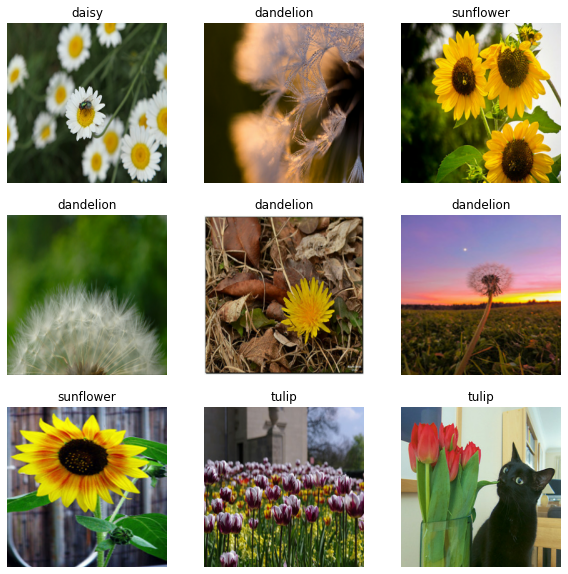

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

## 3. Modelamiento

Vamos a utilizar la arquitectura de un Perceptron Multicapa, la cual s eve de la siguiente manera:

![Multilayer Perceptron](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/MLP.png?raw=true)

Para ello, lo primero que definiremos, será nuestro modelo.

In [ ]:
model = Sequential(name="Mi_primer_MLP")

Capas de Preparación de Datos

In [ ]:
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
model.add(Rescaling(1./255,name='Rescaling_Layer'))
model.add(Flatten(name='Flatten_Layer'))
model.summary()

Model: "Mi_primer_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Capas de Entrenamiento

In [ ]:
model.add(Dense(1000,activation='relu',name='Dense_Layer_1'))
model.add(Dense(100,activation='relu',name='Dense_Layer_2'))
model.add(Dense(512,activation='relu',name='Dense_Layer_3'))
model.add(Dense(50,activation='relu',name='Dense_Layer_4'))
model.add(Dense(20,activation='relu',name='Dense_Layer_5'))
model.add(Dense(10,activation='relu',name='Dense_Layer_6'))
model.summary()

Model: "Mi_primer_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 1000)              196609000 
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               100100    
                                                                 
 Dense_Layer_3 (Dense)       (None, 512)               51712     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25650     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)              

Capa de Salida

In [ ]:
model.add(Dense(len(class_names),activation='softmax',name='Ans_Layer'))
model.summary()

Model: "Mi_primer_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 1000)              196609000 
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               100100    
                                                                 
 Dense_Layer_3 (Dense)       (None, 512)               51712     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25650     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)              

Ya con nuestra arquitectura construida, compilamos nuestro modelo definiendo que función de pérdida, optimizador y métrica vamos a utilizar para construir nuestro modelo.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "Mi_primer_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 1000)              196609000 
                                                                 
 Dense_Layer_2 (Dense)       (None, 100)               100100    
                                                                 
 Dense_Layer_3 (Dense)       (None, 512)               51712     
                                                                 
 Dense_Layer_4 (Dense)       (None, 50)                25650     
                                                                 
 Dense_Layer_5 (Dense)       (None, 20)              

Una manera más amigable de verlo...

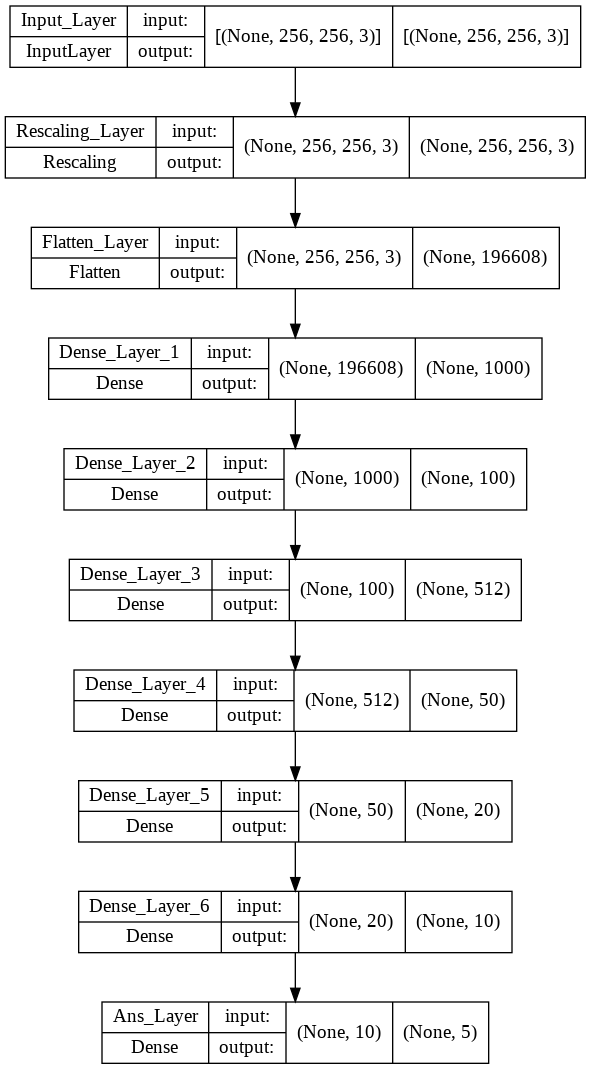

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [ ]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50
    )

Epoch 1/50
69/69 [==============================] - 69s 952ms/step - loss: 1.5877 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.6075 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
69/69 [==============================] - 65s 930ms/step - loss: 1.5423 - precision_1: 0.5263 - recall_1: 0.0046 - val_loss: 1.5608 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
69/69 [==============================] - 64s 924ms/step - loss: 1.4940 - precision_1: 0.5093 - recall_1: 0.0250 - val_loss: 1.4664 - val_precision_1: 0.7000 - val_recall_1: 0.0128
Epoch 4/50
69/69 [==============================] - 63s 915ms/step - loss: 1.4264 - precision_1: 0.5407 - recall_1: 0.0605 - val_loss: 1.4253 - val_precision_1: 0.6875 - val_recall_1: 0.0401
Epoch 5/50
69/69 [==============================] - 64s 922ms/step - loss: 1.3647 - precision_1: 0.5766 - recall_1: 0.1165 - val_loss: 1.3584 - val_precision_1: 0.7042 - val_recall_1: 0.0911
Epoch 6/50
69/69 [===

### 3.1.2. Predicción

Al igual que con nuestros modelos anteriores, podemos realizar las predicciones de nuestro conjunto de datos. Sin embargo, acá hay que realizar una pequeña correción.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], dtype=float32), array([[0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]))

Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.94      0.68      0.79       396
   dandelion       0.75      0.88      0.81       521
        rose       0.77      0.88      0.82       396
   sunflower       0.77      0.96      0.86       400
       tulip       0.86      0.62      0.72       484

   micro avg       0.80      0.80      0.80      2197
   macro avg       0.82      0.80      0.80      2197
weighted avg       0.82      0.80      0.80      2197
 samples avg       0.80      0.80      0.80      2197



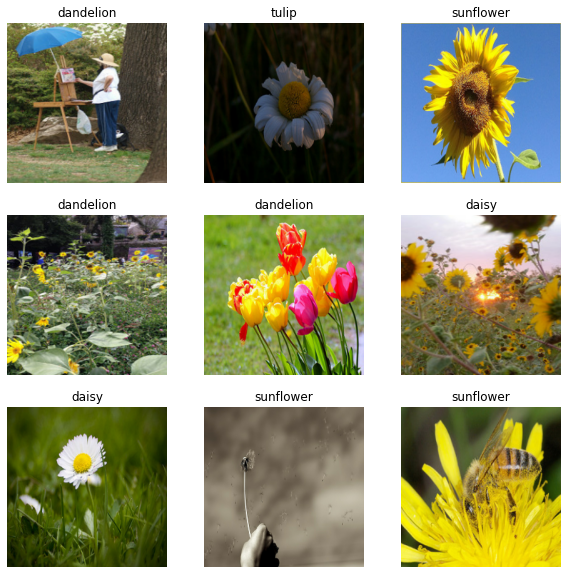

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = model.predict(df)
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

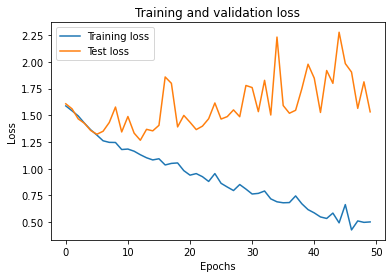

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

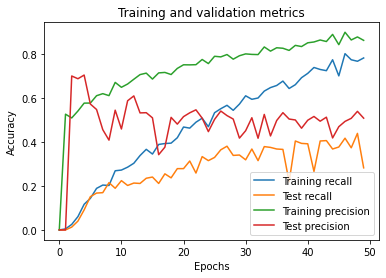

In [ ]:
plt.plot(history.history['recall_1'], label='Training recall')
plt.plot(history.history['val_recall_1'], label='Test recall')
plt.plot(history.history['precision_1'], label='Training precision')
plt.plot(history.history['val_precision_1'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. Validación

Y podemos realizar los mismos pasos, pero esta vez con nuestros datos de entrenamiento.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32), array([[0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.65      0.25      0.36       105
   dandelion       0.41      0.58      0.49       125
        rose       0.33      0.39      0.36       101
   sunflower       0.46      0.69      0.55        95
       tulip       0.34      0.20      0.25       123

   micro avg       0.42      0.42      0.42       549
   macro avg       0.44      0.42      0.40       549
weighted avg       0.43      0.42      0.40       549
 samples avg       0.42      0.42      0.42       549



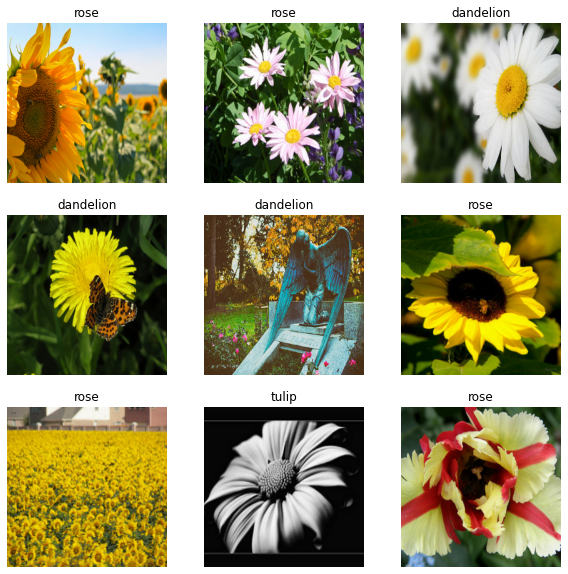

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
pred = model.predict(df)
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

### Búsqueda de Hiperparámetros

Hay muchos hiperparámetros por entonar en el modelo, afortunadamente podemos seguir utilizando GridSearch. Sin embargo, no lo recomendamos debido a la gran cantidad de hiperparámetros que hay que entrenar. 

Para ello, construimos una función que nos permita construir la Red Neuronal esperada y utilizamos la función [RandomizedSearchCV](https://keras.io/guides/keras_tuner/getting_started/) integrada directamente con Keras.

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Mi_Red')
    output = len(class_names)
    n_layers = hp.Choice('n_layers', [5, 6, 7])
    neuronas = hp.Choice('units', ['[1000, 100, 512, 256, 20, 456, 40]','[512,256,128,256,64,32,16]','[1000,500,200,100,50,20,10]'])
    neuronas = eval(neuronas)
    dropout = hp.Choice('dropout', [0.1,0.2,0.3])

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
    clf.add(Rescaling(1./255,name='Rescaling_Layer'))
    clf.add(Flatten(name='Flatten_Layer'))

    for i in range(n_layers):
        clf.add(Dense(neuronas[i], activation=hp.Choice('activacion_oculta', ['relu','sigmoid']), name = 'Capa_Oculta_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida'))

    clf.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    seed=123,
    max_trials=10)

Ya con nuestros valores de búsqueda definidos dentro de nuestra función, y nuestro objeto tuner inizializado. Podemor realizar la búsqueda de los hierparámetros como ya hemos venido realizandolo.

**Nota**: Para este paso, utilizamos el GPU de la máquina de Google Colab, con el fin de realizar el proceso de entrenamiento mucho más rapido.

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 05m 44s]
val_accuracy: 0.4790528118610382

Best val_accuracy So Far: 0.4790528118610382
Total elapsed time: 00h 49m 02s
INFO:tensorflow:Oracle triggered exit


Y realizamos la descarga de nuestro modelo, junto con la vizualización de la arquitectura escogida por la búsqueda Aleatoria.

In [ ]:
best_model.save('best_model_flower.h5')
best_model.summary()

Model: "Mi_Red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 Flatten_Layer (Flatten)     (None, 196608)            0         
                                                                 
 Capa_Oculta_0 (Dense)       (None, 1000)              196609000 
                                                                 
 Dropout_0.1_0 (Dropout)     (None, 1000)              0         
                                                                 
 Capa_Oculta_1 (Dense)       (None, 100)               100100    
                                                                 
 Dropout_0.1_1 (Dropout)     (None, 100)               0         
                                                                 
 Capa_Oculta_2 (Dense)       (None, 512)               51712

Realizamos los mismos pasos que hicimos con nuestro modelo base, para poder comparar 

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32), array([[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.52      0.53      0.52       396
   dandelion       0.53      0.63      0.58       521
        rose       0.75      0.51      0.60       396
   sunflower       0.65      0.84      0.73       400
       tulip       0.61      0.50      0.55       484

   micro avg       0.60      0.60      0.60      2197
   macro avg       0.61      0.60      0.60      2197
weighted avg       0.61      0.60      0.59      2197
 samples avg       0.60      0.60      0.60      2197



In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]], dtype=float32), array([[0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.44      0.45      0.45       105
   dandelion       0.40      0.51      0.45       125
        rose       0.57      0.36      0.44       101
   sunflower       0.55      0.67      0.61        95
       tulip       0.50      0.42      0.46       123

   micro avg       0.48      0.48      0.48       549
   macro avg       0.49      0.48      0.48       549
weighted avg       0.49      0.48      0.48       549
 samples avg       0.48      0.48      0.48       549

